# NYC Taxi Trip Duration 프로젝트
## 6 Sigma 팀 (조현윤, 이상협, 정하연)


### Objective: Build a model that predicts the total ride duration of taxi trips in NYC.

- train.csv - the training set 
- test.csv - the testing set 

Data fields:

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle - memory before sending to the vendor because the vehicle did not have a connection to - the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

link: 
https://github.com/JKeun/dss-regression-datasets/tree/master/project-nyc-taxi-trip-duration-data

In [1]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
import warnings
sns.set()
warnings.filterwarnings('ignore')
#import datetime as dt

from math import atan2, radians, sin, cos, sqrt

# Calculate Distance using longitude & latitude between two points.
def CalDistance(row):
    R = 6367.0
    lat1 = radians(row['pickup_longitude'])
    lon1 = radians(row['pickup_latitude'])
    lat2 = radians(row['dropoff_longitude'])
    lon2 = radians(row['dropoff_latitude'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon /2 ) **2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance


C:\Users\pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dtrain = pd.read_csv('./data/train.csv', parse_dates=['pickup_datetime'])# `parse_dates` will recognize the column is date time
#dtest = pd.read_csv('./data/test.csv', parse_dates=['pickup_datetime'])


In [12]:
dtest = pd.read_csv('./data/test.csv', parse_dates=['pickup_datetime'])

In [3]:
dtrain.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3495688,1,2016-04-30 23:59:00,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454
1,id3051282,1,2016-04-30 23:59:00,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409
2,id0082851,1,2016-04-30 23:59:00,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081
3,id0515725,2,2016-04-30 23:58:00,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800
4,id1872374,2,2016-04-30 23:58:00,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151


In [4]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null datetime64[ns]
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 58.9+ MB


In [13]:
for df in (dtrain,dtest):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hr']    = df['pickup_datetime'].dt.hour
    df['minute']= df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

               id  vendor_id     pickup_datetime dropoff_datetime  \
0       id3495688          1 2016-04-30 23:59:00      5/1/16 0:24   
1       id3051282          1 2016-04-30 23:59:00      5/1/16 0:22   
2       id0082851          1 2016-04-30 23:59:00      5/1/16 0:17   
3       id0515725          2 2016-04-30 23:58:00      5/1/16 0:12   
4       id1872374          2 2016-04-30 23:58:00      5/1/16 0:17   
5       id0312189          1 2016-04-30 23:58:00      5/1/16 0:25   
6       id1462929          1 2016-04-30 23:58:00      5/1/16 0:34   
7       id3799362          1 2016-04-30 23:58:00      5/1/16 0:39   
8       id3607754          2 2016-04-30 23:58:00      5/1/16 0:24   
9       id1733007          2 2016-04-30 23:58:00      5/1/16 0:37   
10      id2384995          2 2016-04-30 23:58:00      5/1/16 0:01   
11      id1368707          1 2016-04-30 23:58:00      5/1/16 0:07   
12      id1885646          1 2016-04-30 23:57:00      5/1/16 0:01   
13      id0475908          1 2016-

               id  vendor_id     pickup_datetime  passenger_count  \
0       id2332349          2 2016-06-30 23:59:00                5   
1       id2013516          1 2016-06-30 23:59:00                2   
2       id3719493          2 2016-06-30 23:59:00                1   
3       id0376262          1 2016-06-30 23:59:00                2   
4       id2105228          1 2016-06-30 23:58:00                1   
5       id1276841          1 2016-06-30 23:58:00                1   
6       id3016059          2 2016-06-30 23:58:00                1   
7       id3952659          2 2016-06-30 23:58:00                2   
8       id1255468          2 2016-06-30 23:58:00                1   
9       id3049611          1 2016-06-30 23:58:00                2   
10      id3095932          1 2016-06-30 23:57:00                1   
11      id1517676          2 2016-06-30 23:57:00                1   
12      id1510711          2 2016-06-30 23:57:00                2   
13      id2008685          1 2016-

In [14]:
dtest.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,day,hr,minute
0,id2332349,2,2016-06-30 23:59:00,5,-73.998291,40.722618,-73.971779,40.762470,0,2016,6,30,23,59
1,id2013516,1,2016-06-30 23:59:00,2,-73.955109,40.689564,-73.978203,40.685802,0,2016,6,30,23,59
2,id3719493,2,2016-06-30 23:59:00,1,-73.978416,40.791576,-73.973160,40.675968,0,2016,6,30,23,59
3,id0376262,1,2016-06-30 23:59:00,2,-73.873093,40.774097,-73.926704,40.856739,0,2016,6,30,23,59
4,id2105228,1,2016-06-30 23:58:00,1,-73.979416,40.755211,-74.003548,40.738224,0,2016,6,30,23,58


In [15]:
dtrain.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hr,minute
0,id3495688,1,2016-04-30 23:59:00,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,0,1454,2016,4,30,23,59
1,id3051282,1,2016-04-30 23:59:00,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,0,1409,2016,4,30,23,59
2,id0082851,1,2016-04-30 23:59:00,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,0,1081,2016,4,30,23,59
3,id0515725,2,2016-04-30 23:58:00,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,0,800,2016,4,30,23,58
4,id1872374,2,2016-04-30 23:58:00,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,0,1151,2016,4,30,23,58


In [17]:
dtrain = dtrain.assign(log_trip_duration = np.log(dtrain.trip_duration+1))

In [18]:
holiday = pd.read_csv('./data/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [19]:
time_data = pd.DataFrame(index = range(len(dtrain)))
time_test = pd.DataFrame(index = range(len(dtest)))

In [21]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [22]:
rest_day,weekend = restday(dtrain.year,dtrain.month,dtrain.day,holidays)
time_data = time_data.assign(rest_day=rest_day)
time_data = time_data.assign(weekend=weekend)

rest_day,weekend = restday(dtest.year,dtest.month,dtest.day,holidays)
time_test = time_test.assign(rest_day=rest_day)
time_test = time_test.assign(weekend=weekend)

In [24]:
time_data = time_data.assign(pickup_time = dtrain.hr+dtrain.minute/60)#float value. E.g. 7.5 means 7:30 am
time_test = time_test.assign(pickup_time = dtest.hr+dtest.minute/60)

In [25]:
time_data.head()

,rest_day,weekend,pickup_time
0,True,True,23.983333
1,True,True,23.983333
2,True,True,23.983333
3,True,True,23.966667
4,True,True,23.966667


In [26]:
fastrout1 = pd.read_csv('./data/fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout2 = pd.read_csv('./data/fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


In [27]:
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))

In [28]:
osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2


In [29]:
dtrain = dtrain.join(osrm_data.set_index('id'), on='id')
dtrain.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,day,hr,minute,log_trip_duration,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id3495688,1,2016-04-30 23:59:00,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,0,...,4,30,23,59,7.282761,10010.9,861.2,17,4,5
1,id3051282,1,2016-04-30 23:59:00,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,0,...,4,30,23,59,7.251345,10357.0,786.3,15,3,5
2,id0082851,1,2016-04-30 23:59:00,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,0,...,4,30,23,59,6.986566,9275.8,703.9,13,3,4


In [30]:
osrm_test = pd.read_csv('./data/fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4


In [31]:
dtest = dtest.join(osrm_test.set_index('id'), on='id')

In [32]:
osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4
3,id3684027,931.8,84.2,4,2,1
4,id3101285,2501.7,294.7,8,3,3


In [33]:
osrm_data = dtrain[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = dtest[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

In [35]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [36]:
List_dist = []
for df in (dtrain,dtest):
    lat1, lng1, lat2, lng2 = (df['pickup_latitude'].values, df['pickup_longitude'].values, 
                              df['dropoff_latitude'].values,df['dropoff_longitude'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(manhattan_dist = dummy_manhattan_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)
Other_dist_data,Other_dist_test = List_dist

In [37]:
coord_pickup = np.vstack((dtrain[['pickup_latitude', 'pickup_longitude']].values,                  
                          dtest[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((dtrain[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           dtest[['dropoff_latitude', 'dropoff_longitude']].values))

In [38]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (dtrain,dtest):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

In [39]:
kmean10_data = dtrain[['pickup_dropoff_loc']]
kmean10_test = dtest[['pickup_dropoff_loc']]

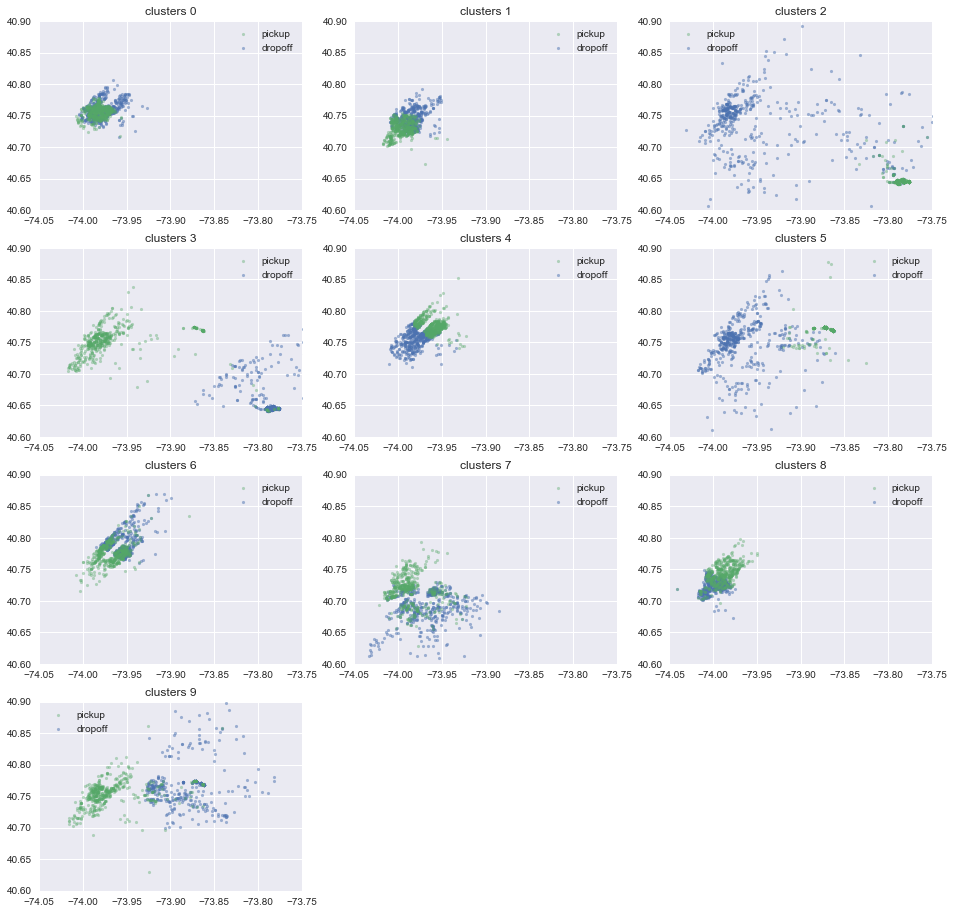

In [40]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = dtrain[dtrain.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

In [42]:
weather = pd.read_csv('./data/KNYC_Metars.csv', parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


In [43]:
print('The Events has values {}.'.format(str(set(weather.Events))))

The Events has values {'None', 'Rain', 'Fog', 'Fog\n\t,\nRain', 'Snow', 'Fog\n\t,\nSnow'}.


In [44]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]

In [45]:
dtrain = pd.merge(dtrain, weather, on = ['month', 'day', 'hr'], how = 'left')
dtest = pd.merge(dtest, weather, on = ['month', 'day', 'hr'], how = 'left')

In [46]:
weather_data = dtrain[['Temp.','Precip','snow','Visibility']]
weather_test = dtest[['Temp.','Precip','snow','Visibility']]

In [47]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,10.6,0.0,0.0,16.1
1,10.6,0.0,0.0,16.1
2,10.6,0.0,0.0,16.1
3,10.6,0.0,0.0,16.1
4,10.6,0.0,0.0,16.1


In [48]:
outliers=np.array([False]*len(dtrain))

In [49]:
print('There are %d rows that have missing values'%sum(dtrain.isnull().any(axis=1)))

There are 8144 rows that have missing values


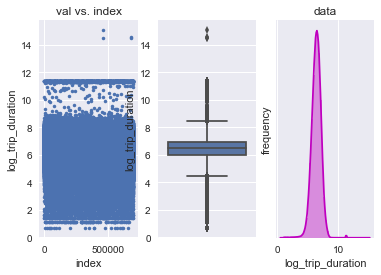

In [51]:
y = np.array(dtrain.log_trip_duration)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('log_trip_duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=dtrain.log_trip_duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('log_trip_duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

In [52]:
outliers[y>12]=True
print('There are %d entries that have trip duration too long'% sum(outliers))

There are 4 entries that have trip duration too long


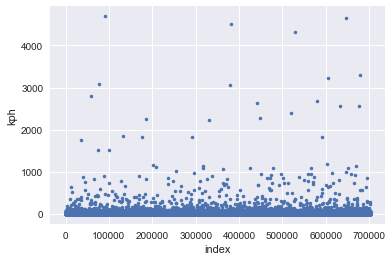

In [54]:
kph = osrm_data.total_distance/1000/dtrain.trip_duration*3600
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

['pickup_longitude', 'dropoff_longitude']


ValueError: Item wrong length 701778 instead of 701774.

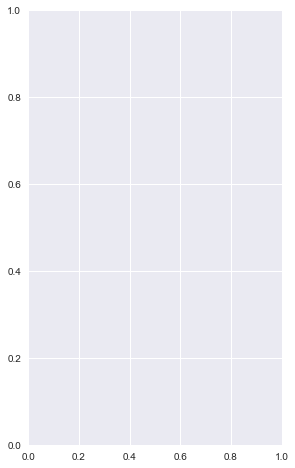

In [70]:

fig=plt.figure(figsize=(10, 8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    print (loc)
    plt.subplot(1,2,i+1)
    sns.boxplot(dtrain=dtrain[outliers==False], order=loc);#plt.title(loc)

In [61]:
outliers[dtrain.pickup_longitude<-110]=True
outliers[dtrain.dropoff_longitude<-110]=True
outliers[dtrain.pickup_latitude>45]=True
print('There are total %d entries of ouliers'% sum(outliers))

There are total 4 entries of ouliers


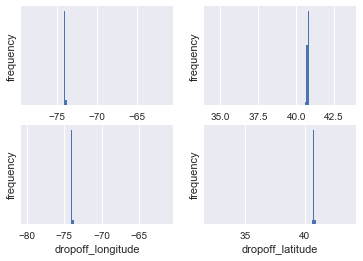

In [62]:
for i,feature in enumerate(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']):
    plt.subplot(2,2,i+1)
    dtrain[outliers==False][feature].hist(bins=100)
    plt.xlabel(feature);plt.ylabel('frequency');plt.yticks([])
#plt.show();plt.close()